In [42]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

plt.style.use('default')

with open('utils/movie/backward_sequencing_related.pkl', 'rb') as f:
    backward_sequencing_related = pickle.load(f)
with open('utils/movie/forward_sequencing_related.pkl', 'rb') as f:
    forward_sequencing_related = pickle.load(f)

sequencing_moments = np.zeros(610)
sequencing_distance = []
for pair in forward_sequencing_related:
    sequencing_distance.append(np.abs(pair[1]-pair[0]))
    sequencing_moments[pair[1]+3:pair[1]+7] = 1  # +3 to +8 due to 1s offset
for pair in backward_sequencing_related:
    sequencing_distance.append(np.abs(pair[1]-pair[0]))
    sequencing_moments[pair[1]-8:pair[1]-4] = 1 # -8 to -3
print(np.sum(sequencing_moments))


condition = sequencing_moments==1
sequencing_length = np.diff(np.where(np.concatenate(([condition[0]],
                                                     condition[:-1] != condition[1:],
                                                     [True])))[0])[::2]
print("original sequencing moments (length)", np.mean(sequencing_length), sem(sequencing_length))

condition = sequencing_moments==0
sequencing_interval = np.diff(np.where(np.concatenate(([condition[0]],
                                                     condition[:-1] != condition[1:],
                                                     [True])))[0])[::2]
print("original sequencing moments (interval)", np.mean(sequencing_interval), sem(sequencing_interval))
print("original sequencing moments (distance to target)", np.mean(sequencing_distance), sem(sequencing_distance))


64.0
original sequencing moments (length) 4.0 0.0
original sequencing moments (interval) 32.11764705882353 7.265896544484768
original sequencing moments (distance to target) 226.0625 34.08267750999032


In [35]:
from scipy.linalg import lstsq

BERT_NSP_matrix = np.load('_DATA/BERT_NSP_values.npy')
semantic_similarity_matrix = np.load('_DATA/semantic_similarity_values.npy')

# Remove the semantic similarity from BERT NSP values
BERT_NSP_matrix_wo_similarity = np.zeros((3,300,300))
for i in range(3):
    semantic_similarity_vector = semantic_similarity_matrix[i,:,:].reshape(-1,1)
    NSP_vector = BERT_NSP_matrix[i,:,:].reshape(-1,1)

    X = np.concatenate([semantic_similarity_vector, np.ones(semantic_similarity_vector.shape)], axis=1)

    coef, residual, _, _ = lstsq(X, NSP_vector)
    nsp_vector_clean = NSP_vector - X.dot(coef)
    BERT_NSP_matrix_wo_similarity[i,:,:] = nsp_vector_clean.reshape((300,300))

BERT_NSP_matrix_wo_similarity = np.mean(BERT_NSP_matrix_wo_similarity, axis=0)
BERT_NSP_matrix_wo_similarity = np.repeat(np.repeat(BERT_NSP_matrix_wo_similarity, 2, axis=0), 2, axis=1)

narrative_coherence = np.zeros(600)
narrative_coherence_target = np.zeros(600)
for i in range(1, 600):
    narrative_coherence[i] = np.max(BERT_NSP_matrix_wo_similarity[:i,i])
    narrative_coherence_target[i] = np.argmax(BERT_NSP_matrix_wo_similarity[:i,i]) #/ (i+1)
narrative_coherence_without_hrf = np.copy(narrative_coherence)

from nltools.external import glover_hrf
hrf_weight = glover_hrf(tr=1, oversampling=1)
narrative_coherence = np.convolve(narrative_coherence, hrf_weight)[:610]

0.4 4 10
0.25 5 20
0.16666666666666666 5 30
0.15 6 40
0.14 7 50
0.15 9 60
0.15714285714285714 11 70


(0.0, 0.5)

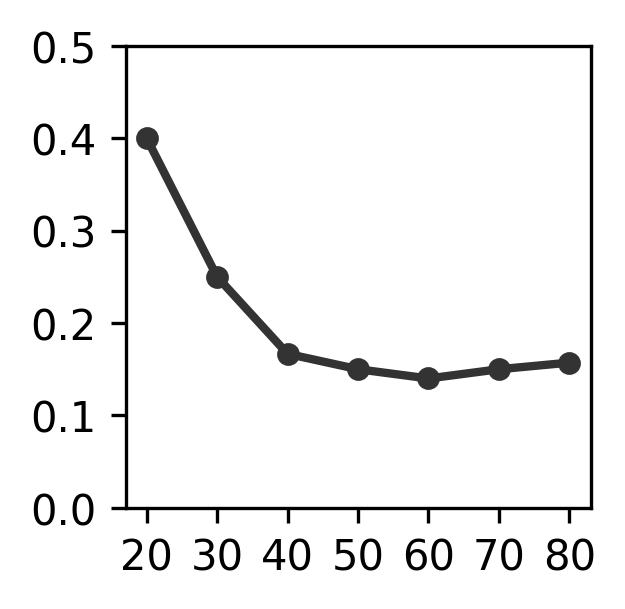

In [27]:
def get_LLM_sequencing_moments(n, index=narrative_coherence):
    LLM_sequencing_moments = np.zeros(610)
    for i in np.argsort(index)[::-1][:n]:
        LLM_sequencing_moments[i] = 1
    return LLM_sequencing_moments

hit_ratios = []
for i in [10,20,30,40,50,60,70]:
    LLM_sequencing_moments = get_LLM_sequencing_moments(i)
    hit = 0
    count = 0
    for t in range(610):
        if LLM_sequencing_moments[t] == 1:
            if sequencing_moments[t]==1:
                hit += 1
            count += 1
    print(hit/count, hit, count)
    hit_ratios.append(hit/count)

plt.figure(figsize=(2,2), dpi=300)
plt.plot([0,1,2,3,4,5,6], hit_ratios, c='#333333', lw=2)
plt.scatter([0,1,2,3,4,5,6], hit_ratios, c='#333333', s=20, zorder=100)
plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
plt.ylim(0, 0.5)

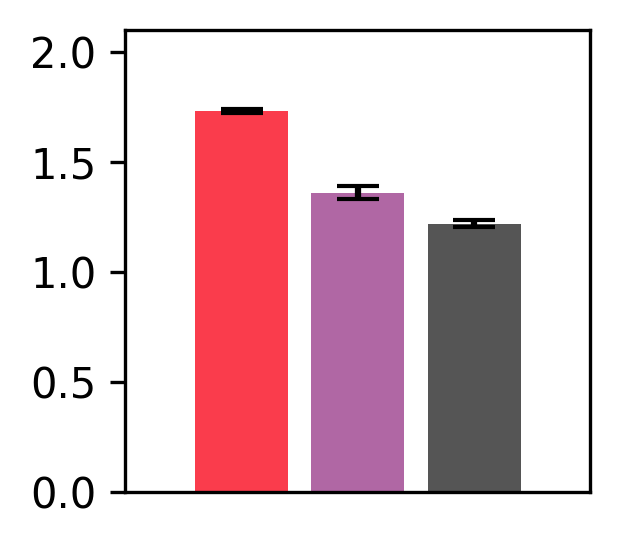

1.3582835771154556
1.2172054973417856
1.7296300030554763
TtestResult(statistic=2.9095716040490314, pvalue=0.0037515722165501653, df=608.0)
TtestResult(statistic=9.542719824405408, pvalue=3.555861716856891e-20, df=594.0)
TtestResult(statistic=10.793046748054275, pvalue=4.77224091594536e-19, df=112.0)


In [28]:
from scipy.stats import sem, ttest_ind

# Assuming BERT_retrieval and retrieval_moments are already defined
mean_retrieval_moments_1 = np.mean(narrative_coherence[sequencing_moments == 1])
mean_retrieval_moments_0 = np.mean(narrative_coherence[sequencing_moments == 0])
mean_top_50_retrieval = np.mean(np.sort(narrative_coherence)[::-1][:50])

# Calculate standard error of the mean (SEM)
sem_retrieval_moments_1 = sem(narrative_coherence[sequencing_moments == 1])
sem_retrieval_moments_0 = sem(narrative_coherence[sequencing_moments == 0])
sem_top_50_retrieval = sem(np.sort(narrative_coherence)[::-1][:50])

# Data for plotting
means = [mean_top_50_retrieval, mean_retrieval_moments_1, mean_retrieval_moments_0]
errors = [sem_top_50_retrieval, sem_retrieval_moments_1, sem_retrieval_moments_0]

# Create the bar plot with error bars
plt.figure(figsize=(2,2), dpi=300)
plt.bar(np.arange(3), means, yerr=errors, capsize=5, color=['#fa3c4c', '#B067A4', '#555555'])
plt.xlim(-1, 3)
plt.yticks([0, 0.5, 1.0, 1.5, 2.0])
plt.ylim(None, 2.1)
plt.xticks([])
plt.show()

print(np.mean(narrative_coherence[sequencing_moments==1]))
print(np.mean(narrative_coherence[sequencing_moments==0]))
print(np.mean(np.sort(narrative_coherence)[::-1][:50]))
print(ttest_ind(narrative_coherence[sequencing_moments==1], narrative_coherence[sequencing_moments==0]))
print(ttest_ind(np.sort(narrative_coherence)[::-1][:50], narrative_coherence[sequencing_moments==0]))
print(ttest_ind(np.sort(narrative_coherence)[::-1][:50], narrative_coherence[sequencing_moments==1]))

In [12]:
content_score = np.load("_DATA/content_score.npy")
ordering_score = np.load("_DATA/ordering_score.npy")

with open(f'_DATA/hippocampo_cortical_FC_narrative_coherence.pkl', 'rb') as f:
    hippocampo_cortical_FC = pickle.load(f)
atlas_idx = 1

roi = 191 -1

(-0.58, 0.15)

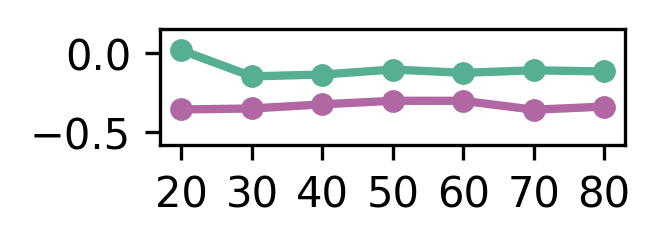

In [13]:
from scipy.stats import pearsonr

plt.figure(figsize=(2,0.5), dpi=300)
FC_ordering_correlations = []
FC_content_correlations = []
for i in range(1,8):
    y = hippocampo_cortical_FC[atlas_idx][:,roi, i]
    y = np.arctanh(y)
    x = ordering_score
    r, p = pearsonr(x, y)
    FC_ordering_correlations.append(r)
    x = content_score
    r, p = pearsonr(x, y)
    FC_content_correlations.append(r)
plt.plot(FC_ordering_correlations, c='#B067A4', lw=2, zorder=100)
plt.scatter([0,1,2,3,4,5,6], FC_ordering_correlations, c='#B067A4', s=20, zorder=100)
plt.plot(FC_content_correlations, c='#56AE93', lw=2, zorder=100)
plt.scatter([0,1,2,3,4,5,6], FC_content_correlations, c='#56AE93', s=20, zorder=100)

plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
#plt.grid(True, zorder=0)
plt.ylim(-0.58, 0.15)

(-0.2, 1.2)

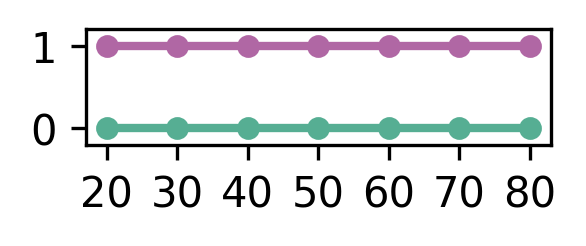

In [14]:
def proportion_of_selection(x, y):
    n_subjects = 65
    count = 0
    for s in range(n_subjects):
        mask = np.ones(n_subjects)
        mask[s] = 0
        r, p = pearsonr(x[mask==1], y[mask==1])
        if p < 0.05:
            count += 1
    return count/n_subjects

plt.figure(figsize=(2,0.5), dpi=300)
FC_ordering_correlations = []
FC_content_correlations = []
for i in range(1,8):
    y = hippocampo_cortical_FC[atlas_idx][:,roi, i]
    y = np.arctanh(y)
    x = ordering_score
    FC_ordering_correlations.append(proportion_of_selection(x, y))
    x = content_score
    FC_content_correlations.append(proportion_of_selection(x, y))
plt.plot(FC_ordering_correlations, c='#B067A4', lw=2, zorder=100)
plt.scatter([0,1,2,3,4,5,6], FC_ordering_correlations, c='#B067A4', s=20, zorder=100)
plt.plot(FC_content_correlations, c='#56AE93', lw=2, zorder=100)
plt.scatter([0,1,2,3,4,5,6], FC_content_correlations, c='#56AE93', s=20, zorder=100)

plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
plt.ylim(-0.2, 1.2)

10 [4 2 2 1 1] 2.0 0.5477225575051661
20 [4 2 4 3 3 1 3] 2.857142857142857 0.40406101782088427
30 [ 5  2  1  4  3  2 10  3] 3.75 0.9955257046261682
40 [ 5  3  3  2  4  3  4 10  4  2] 4.0 0.7302967433402214
50 [ 5  9  1  4  4  4  5 11  4  3] 5.0 0.9189365834726814
60 [ 7  2  1  9  2  4  5  4  5 12  5  4] 5.0 0.896119580764924
70 [ 7  3  1  9  3  5  6  4  7  3 12  6  4] 5.384615384615385 0.812864999187044


([<matplotlib.axis.XTick at 0x7f5a5485d4e0>,
 [Text(0, 0, '20'),
  Text(1, 0, '30'),
  Text(2, 0, '40'),
  Text(3, 0, '50'),
  Text(4, 0, '60'),
  Text(5, 0, '70'),
  Text(6, 0, '80')])

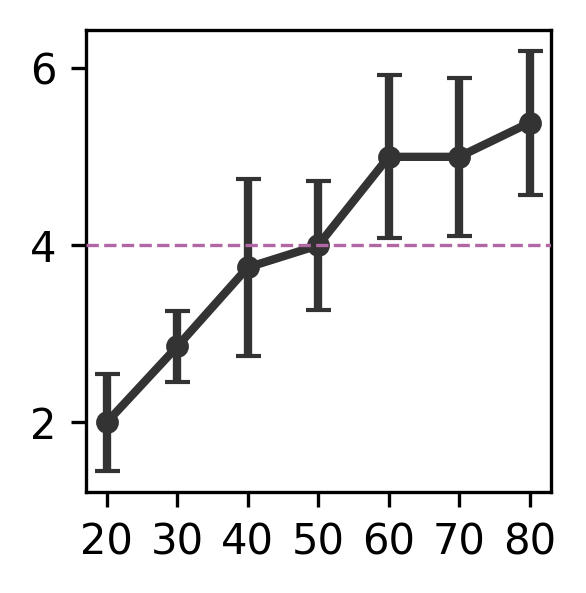

In [39]:
from scipy.stats import sem

mean_length = []
sem_length = []
for i in [10,20,30,40,50,60,70]:
    LLM_sequencing_moments = get_LLM_sequencing_moments(i)
    condition = LLM_sequencing_moments==1
    sequencing_length = np.diff(np.where(np.concatenate(([condition[0]],
                                                         condition[:-1] != condition[1:],
                                                         [True])))[0])[::2]
    mean_length.append(np.mean(sequencing_length))
    sem_length.append(sem(sequencing_length))
    print(i, sequencing_length, np.mean(sequencing_length), sem(sequencing_length))

plt.figure(figsize=(2,2), dpi=300)
plt.errorbar([0,1,2,3,4,5,6], mean_length, yerr=sem_length, c='#333333', lw=2, capsize=3)
plt.scatter([0,1,2,3,4,5,6], mean_length, c='#333333', s=20, zorder=100)
plt.axhline(4, c='#B067A4', lw=0.8, linestyle='--', zorder=100)
plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
#plt.ylim(0, 0.5)

10 [211 208  23  59  30  69] 100.0 35.33459117257951
20 [211 150  55  21  58   4  23  68] 73.75 25.18059768949101
30 [210 150  36  18  21  11  44  22  68] 64.44444444444444 23.108506797708785
40 [210 150   1  30  18  21  10  43  22  14  51] 51.81818181818182 19.990824341463252
50 [210 149  18   9  17  21   9  41  22  13  51] 50.90909090909091 19.98702058175598
60 [209  24  91  30  17   9  16  21   9  41  20  13  50] 42.30769230769231 15.205171444570333
70 [209  23  91  30  17   7  16  20   8  15  22  20  12  50] 38.57142857142857 14.329986344523256


([<matplotlib.axis.XTick at 0x7f5a548bd330>,
 [Text(0, 0, '20'),
  Text(1, 0, '30'),
  Text(2, 0, '40'),
  Text(3, 0, '50'),
  Text(4, 0, '60'),
  Text(5, 0, '70'),
  Text(6, 0, '80')])

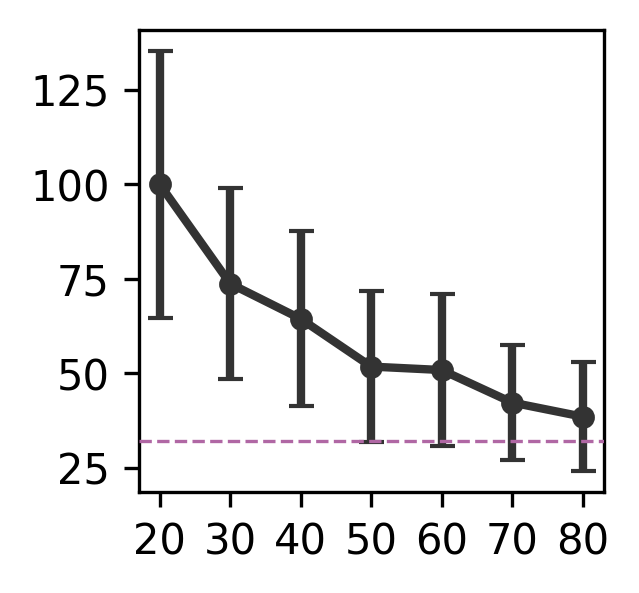

In [43]:
from scipy.stats import sem

mean_distance = []
sem_distance = []
for i in [10,20,30,40,50,60,70]:
    LLM_sequencing_moments = get_LLM_sequencing_moments(i)
    condition = LLM_sequencing_moments==0
    sequencing_length = np.diff(np.where(np.concatenate(([condition[0]],
                                                         condition[:-1] != condition[1:],
                                                         [True])))[0])[::2]
    mean_distance.append(np.mean(sequencing_length))
    sem_distance.append(sem(sequencing_length))
    print(i, sequencing_length, np.mean(sequencing_length), sem(sequencing_length))

plt.figure(figsize=(2,2), dpi=300)
plt.errorbar([0,1,2,3,4,5,6], mean_distance, yerr=sem_distance, c='#333333', lw=2, capsize=3)
plt.scatter([0,1,2,3,4,5,6], mean_distance, c='#333333', s=20, zorder=100)
plt.axhline(32.11764705882353, c='#B067A4', lw=0.8, linestyle='--', zorder=100)
plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])
#plt.ylim(0, 0.5)

10 224.9 131.83963743882188
20 175.5 110.00568167144823
30 169.7 103.1717500093897
40 168.6 101.54427605729434
50 157.94 100.3949022610212
60 177.9 110.93191605665163
70 167.0142857142857 117.84196352465848


([<matplotlib.axis.XTick at 0x7f5a5472c460>,
 [Text(0, 0, '20'),
  Text(1, 0, '30'),
  Text(2, 0, '40'),
  Text(3, 0, '50'),
  Text(4, 0, '60'),
  Text(5, 0, '70'),
  Text(6, 0, '80')])

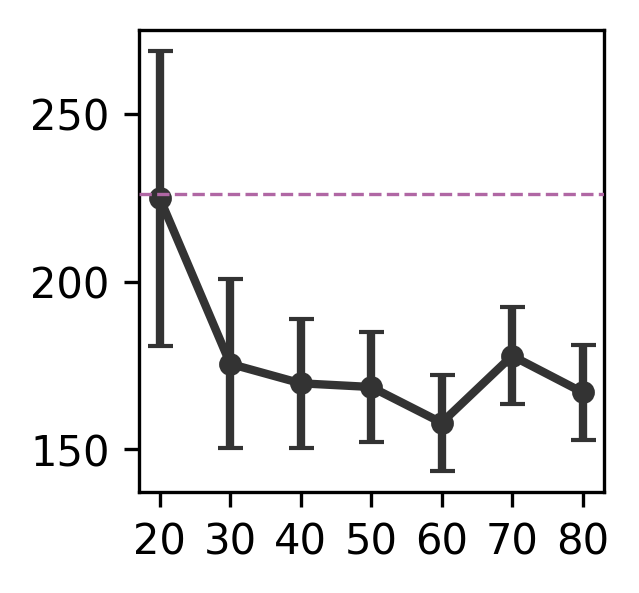

In [44]:
from scipy.stats import sem
mean_distance = []
sem_distance = []
for n in [10,20,30,40,50,60,70]:
    distance = []
    for i in np.argsort(narrative_coherence_without_hrf)[::-1][:n]:
        d = np.abs(narrative_coherence_target[i] - i)
        distance.append(d)
    mean_distance.append(np.mean(distance))
    sem_distance.append(sem(distance))
    print(n, np.mean(distance), np.std(distance))

plt.figure(figsize=(2,2), dpi=300)
plt.errorbar([0,1,2,3,4,5,6], mean_distance, yerr=sem_distance, c='#333333', lw=2, capsize=3)
plt.scatter([0,1,2,3,4,5,6], mean_distance, c='#333333', s=20, zorder=100)
plt.axhline(226.0625, c='#B067A4', lw=0.8, linestyle='--', zorder=100)
plt.xticks([0,1,2,3,4,5,6], [20,30,40,50,60,70,80])